In [46]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

sys.path.append(os.path.abspath(".."))
from utils import load_data, preprocess_text

In [45]:
# Set up paths
excel_fpath = r"D:\Priyanshu\Wysa\dataset.xlsx"
mappings_fpath = r"D:\Priyanshu\Wysa\code\mappings\mapping.json"

In [51]:
# Get mappings
with open(mappings_fpath, "r") as file:
    mappings = json.load(file)
file.close()

In [30]:
# Get test data
df_test = load_data(excel_fpath, "Test")
df_test.sample(5)

,tweet
68,@mention --&gt; RT @mention New #UberSocial fo...
343,RT @mention Late night security guard at #sxsw...
391,Google photo booth @mention at the Six Lounge....
15,Shipments daily - follow @mention #AppleATXdt ...
71,"Wow folks, make sure that iPhone ringer is tur..."


In [31]:
# Load models
emotion_recog_model = pipeline(
    "text-classification",
    model=r"D:\Priyanshu\Wysa\checkpoints\emotion_recog\checkpoint-940",
)
brand_product_recog_model = pipeline(
    "text-classification",
    model=r"D:\Priyanshu\Wysa\checkpoints\brand_product_recog\checkpoint-940",
)

In [33]:
def predict(inputs, model):
    if not isinstance(inputs, pd.Series):
        inputs = pd.Series(inputs)
    inputs = inputs.apply(preprocess_text)

    output_list = []
    for inp in inputs.tolist():
        data_dict = model(inp)[0]
        output_list.append(data_dict)
    return output_list

In [53]:
emotion_preds = predict(df_test["tweet"], emotion_recog_model)
category_preds = predict(df_test["tweet"], brand_product_recog_model)

### Confidence-based Analysis
We will analyze the probability (confidence) scores of the model predictions for the tweets in the test set. This will give us some insight into model certainty and can help identify classes the model is/isn't confident about. High confidence scores generally indicate more reliable predictions.

In [ ]:
def get_data_dict(preds):
    data_dict = {}
    for res in preds:
        label, score = res["label"], res["score"]
        if label not in data_dict.keys():
            data_dict[label] = []
        data_dict[label].append(score)
    return data_dict


emotion_data_dict = get_data_dict(emotion_preds)
category_data_dict = get_data_dict(category_preds)

<Figure size 1200x700 with 0 Axes>

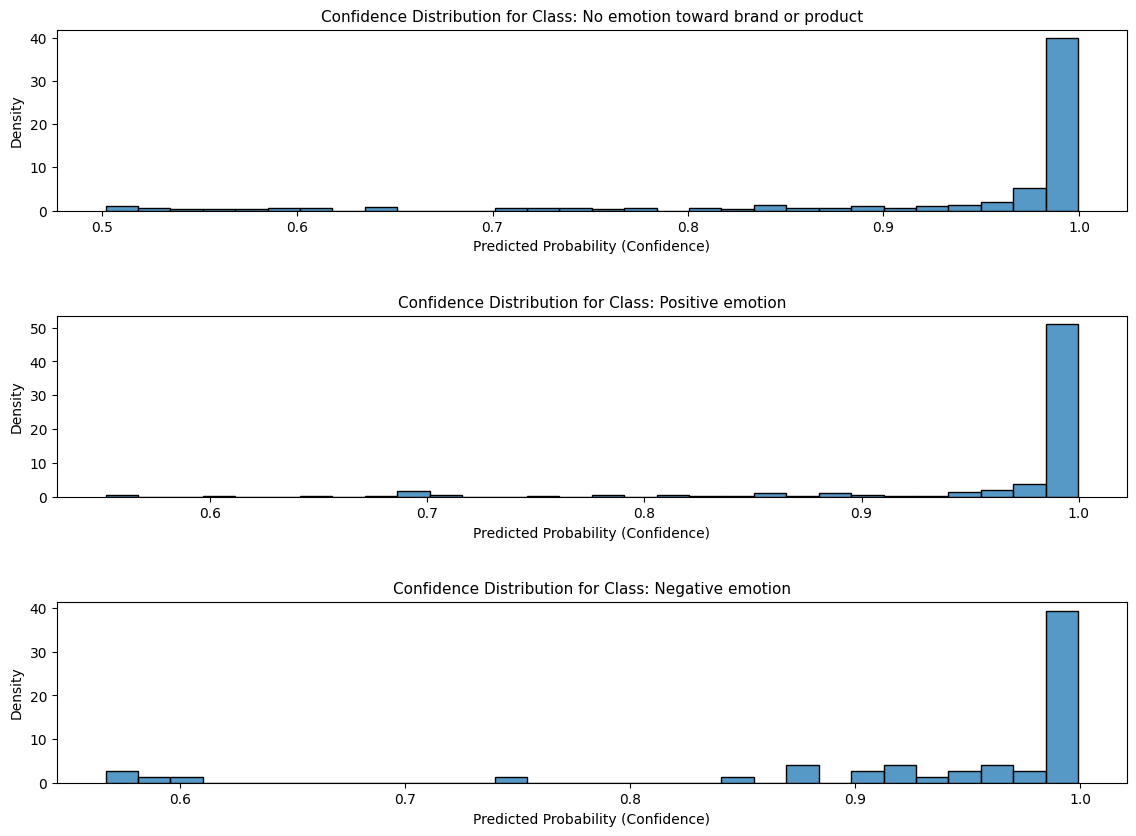

<Figure size 1200x700 with 0 Axes>

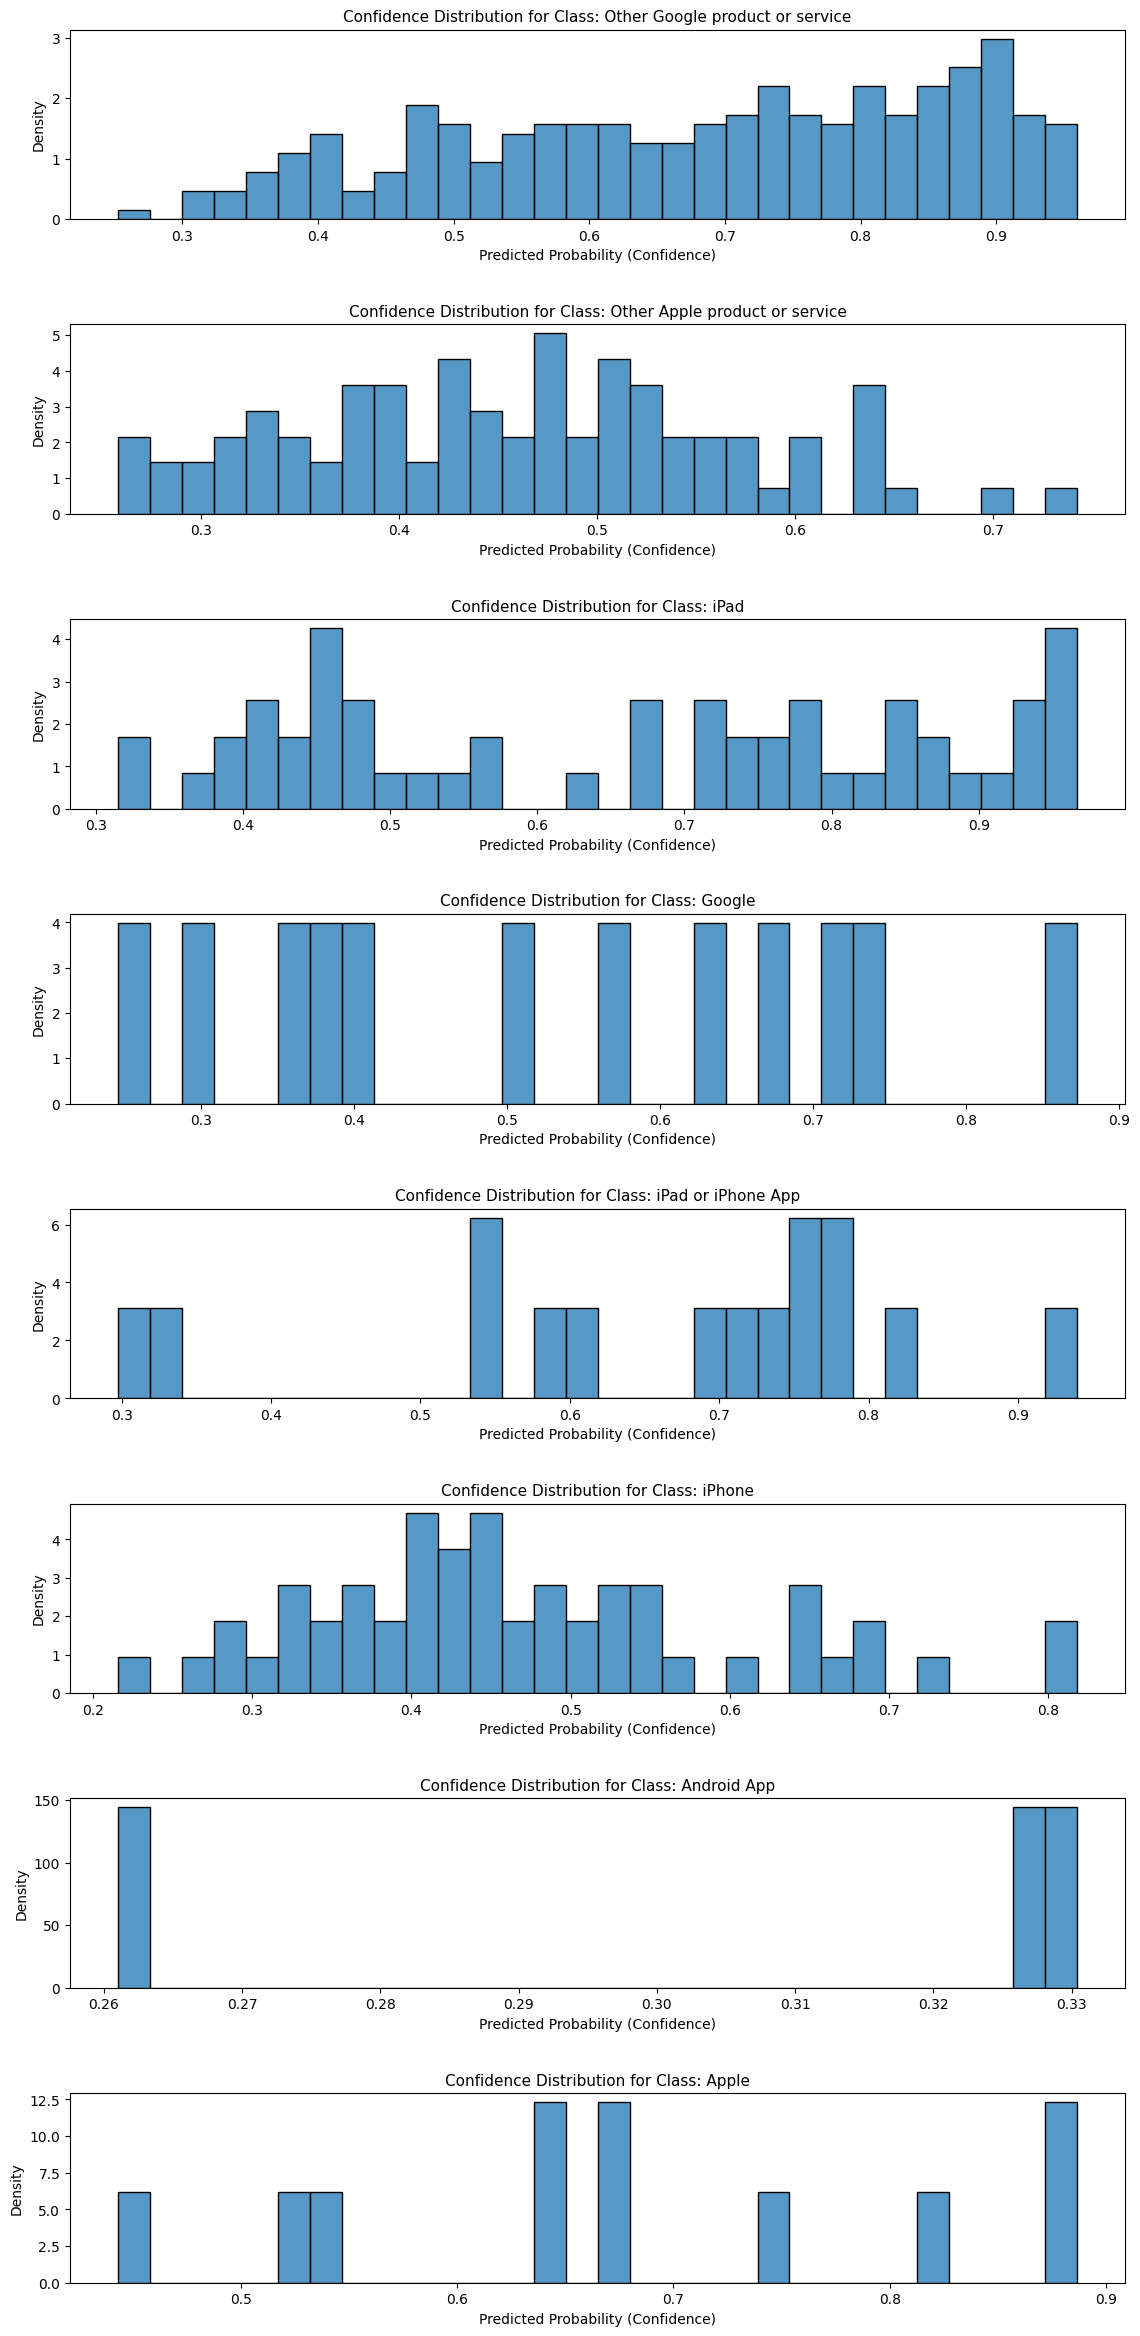

In [ ]:
def plot_confidence_by_class(data_dict, label_to_cls_map):
    cls_to_label_map = {label: cls for cls, label in label_to_cls_map.items()}

    plt.figure(figsize=(12, 7))
    # Creating subplots for each class
    n_classes = len(data_dict.keys())
    fig, axes = plt.subplots(n_classes, 1, figsize=(12, n_classes * 3))

    for i, (key, values) in enumerate(data_dict.items()):
        cls = int(key.split("_")[-1])
        label = cls_to_label_map[cls]

        sns.histplot(values, kde=False, bins=30, ax=axes[i], stat="density")
        axes[i].set_title(f"Confidence Distribution for Class: {label}", fontsize=11)
        axes[i].set_xlabel("Predicted Probability (Confidence)", fontsize=10)
        axes[i].set_ylabel("Density", fontsize=10)

    plt.tight_layout(pad=3.0)
    plt.show()


plot_confidence_by_class(emotion_data_dict, mappings["emotions"])
plot_confidence_by_class(category_data_dict, mappings["categories"])

* We can observe that for emotion recognition, the model's prediction probabilities (confidence scores) are skewed towards higher values, indicating strong confidence and reliability in classifying emotions.

* In contrast, the prediction probabilities (confidence scores) for associated brand/product classes are more spread out, with significant samples have lower confidence. This suggests greater uncertainty and potential challenges in distinguishing these categories. This also tells us that the second model may require further training and optimization.